Output()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
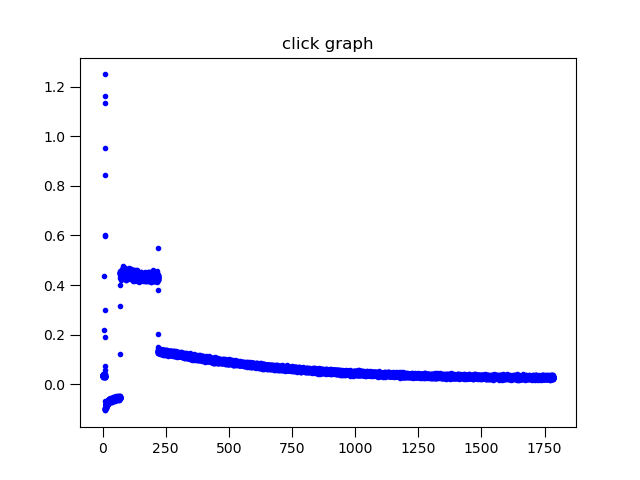

In [21]:
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
from ipywidgets import Output
import glob

plt.rcParams["font.family"] = "sans-serif"

file = "data/csv/20220921 5HB/0/110 490.csv"
data = pd.read_csv(file)
df_data = data.drop(["old_name", "new_name"], axis=1)

file_name = file.split("/")[-1].split(".")[0]
result_dir = "result/" + "/".join(file.split("csv")[1].split("/")[1:-1]) + "/"

df_data = df_data.rename(
    columns={"time " + file_name: "time", "abs " + file_name: "abs"}
)

x = df_data["time"]
y = df_data["abs"]

data_list = []
point_list = []
mask = np.ones(len(x), dtype=bool)
mask[0 : len(x)] = False
# グラフの描画
fig, ax = plt.subplots()
ax.plot(x, y, ".", color="blue", zorder=1)
ax.set_title("click graph")


state = 0
lpoint = 0
rpoint = 0

out = Output()
display(out)

@out.capture(clear_output=True)
def oncpaint(event):
    global state
    global lpoint, rpoint
    ind = np.searchsorted(x, event.xdata)
    # 開始点
    if event.button == 3 and state == 0:
        plt.title("Start point is " + str(ind))
        ax.plot([x[ind]], [y[ind]], ".", color="red", zorder=2)
        fig.canvas.draw()
        value = [event.ydata, event.xdata]
        data_list.append(value)
        state = 1
        lpoint = ind
        print(data_list)
    # 終了点
    elif event.button == 3 and state == 1:
        plt.title("End point is " + str(ind))
        ax.plot([x[ind]], [y[ind]], ".", color="red", zorder=2)
        fig.canvas.draw()
        state = 2
        rpoint = ind + 1
        ax.plot(x[lpoint:rpoint], y[lpoint:rpoint], ".", color="red")
        print(lpoint)
    # キャンセル
    elif event.button == 3 and state == 2:
        plt.title("Canceled")
        state = 0
        ax.plot(x[lpoint:rpoint], y[lpoint:rpoint], ".", color="blue")
    # 決定
    elif event.button == 1 and state == 2:
        plt.title("Approved")
        mask[lpoint:rpoint] = True
        state = 0
        point_list.append([lpoint, rpoint])
        print(lpoint, rpoint)
    # 終了
    elif event.key == "q":
        fig.canvas.mpl_disconnect(cid)


cid = fig.canvas.mpl_connect("button_press_event", oncpaint)
plt.show()

In [22]:
# 選んだ部分をCSVファイルに書き出す
df_list = []
for n in range(len(point_list)):
    dfn = df_data[point_list[n][0] : point_list[n][1]]

    dfn.reset_index(inplace=True)
    dfn = dfn.drop(["index"], axis=1)
    df_list.append(dfn)


df_result = pd.concat(df_list, axis=1)

0.04724409448818896 1192.1856926


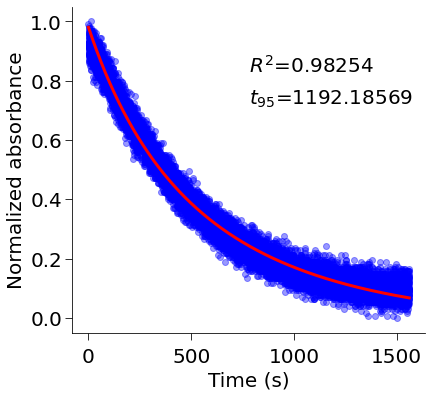

In [23]:
# 非線形回帰

# %matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
from ipywidgets import Output
from scipy.optimize import curve_fit
import seaborn as sns
%matplotlib inline

# TODO Aは定数にしたい

def kinetic_model_f1(x, B, C, D):
    A = 1
    return A*(1-((1-np.exp(D*x))/(1-C*np.exp(D*x)))) + B

# df_result = pd.read_csv("result/20220315/S-Br2/30/480 001.csv")
x = df_result['time'] - df_result['time'][0]
y = (df_result['abs'] - min(df_result['abs'])) / (max(df_result['abs']) - min(df_result['abs']))

# t_95
for i in range(len(x)):
    x_i = x[i]
    y_i = y[i]
    if y_i < 0.05:
        print(y_i, x_i)
        t_95 = x_i
        break

data_kinetic_model_f1 = np.array([x, y])

# パラメーターの初期値 B,C,D
param_init_dict = {
        "data_kinetic_model_f1":[0, 0.6, -0.01]
        }
# グラフ描画用のサンプルデータ
sample_x = np.array(x)


def fit(func, x, param_init):
    """
    func:データxに近似したい任意の関数
    x:データ
    param_init:パラメータの初期値
    popｔ:最適化されたパラメータ
    pocv:パラメータの共分散
    """
    X = x[0]
    Y = x[1]
    popt,pocv=curve_fit(func, X, Y, p0=param_init)
    perr = np.sqrt(np.diag(pocv)) #対角成分が各パラメータの標準誤差に相当
    y=func(sample_x, *popt)
    return y, popt, perr

fit_result = fit(kinetic_model_f1, data_kinetic_model_f1, param_init_dict["data_kinetic_model_f1"])
# R2の計算
residuals =  y - fit_result[0]
rss = np.sum(residuals**2)#residual sum of squares = rss
tss = np.sum((y-np.mean(y))**2)#total sum of squares = tss
r_squared = 1 - (rss / tss)

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 20
#軸主目盛り線の長さ
plt.rcParams["xtick.major.size"] = 7
plt.rcParams["ytick.major.size"] = 7
#x軸補助目盛り線の長さ
plt.rcParams["xtick.minor.size"] = 4

plt.rcParams["legend.frameon"] = False

fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# x軸ラベルの下に空間を生成
# ax.get_xaxis().set_tick_params(pad=8)

# 目盛りを外に出す
ax.tick_params(direction='out')
# 枠線の消去
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Normalized absorbance')
ax.annotate("$R^2$="+str(np.round(r_squared,5)), xy=(0.5, 0.8), xycoords='axes fraction')
ax.annotate("$t_{95}$="+str(np.round(t_95,5)), xy=(0.5, 0.7), xycoords='axes fraction')
fig.subplots_adjust(left=0.2)

ax.scatter(data_kinetic_model_f1[0], data_kinetic_model_f1[1], color="blue", alpha=0.4)
ax.plot(sample_x, fit_result[0], color="red", lw='3')


# 元データ、ノーマライズ後、フィットカーブも追加してcsvへ保存
df_result['norm_time'] = x
df_result['norm_abs'] = y
df_result['fit_curve'] = fit_result[0]
# df_resultの保存 
os.makedirs(result_dir, exist_ok=True)
df_result.to_csv(result_dir + file_name + ".csv", index=False)

In [24]:
opt_B = fit_result[1][0]
opt_C = fit_result[1][1]
opt_D = fit_result[1][2]

k_1 = -opt_D
k_2 = -(opt_C * opt_D)/(1 - opt_C)

column_name = file_name

# 測定条件の入力を詳細に行いたい場合
# temp = 30
# wavelength = 490
# filter_combination_list = ["001", "010", "011", "100", "101", "110"]
# period_3 = 25
# filter_combination = filter_combination_list[1]

# if 'period_3' in locals():
#     column_name = str(temp) + " " + str(period_3) + " " + str(wavelength) + " " + filter_combination
# else:
#     column_name = str(temp) + " " + str(wavelength) + " " + filter_combination
    
opt_columns = ["opt_B", "opt_C", "opt_D", "k_1", "k_2"]
opt_params = np.array([opt_B, opt_C, opt_D, k_1, k_2])

df_opt_params = pd.DataFrame(opt_params, index=opt_columns, columns=[column_name])

df_opt_params

,110 490
opt_B,-0.019652
opt_C,0.382767
opt_D,-0.001286
k_1,0.001286
k_2,0.000797


In [25]:
# fit_resultフォルダに保存し、最後に結合したCSVを出力
# 図も保存
fit_result_dir = result_dir + "fit_result/"
os.makedirs(fit_result_dir, exist_ok=True)
df_opt_params.to_csv(fit_result_dir + column_name + ".csv", index=True)
fig_result_dir = result_dir + "fig_result/"
os.makedirs(fig_result_dir, exist_ok=True)
fig.savefig(fig_result_dir + column_name + ".png")

# ファイルの結合 (解析した結果を一つのcsvにまとめる)

In [26]:
# fit_resultフォルダに保存されたcsvファイルの結合、保存
import glob
import codecs

df_opt_params_all = pd.DataFrame()
data_dir = fit_result_dir + "*.csv"
# 手動
# data_dir = ""
paths = [p for p in glob.glob(data_dir)]

for path in paths:
    with codecs.open(path, "r", "UTF-8", "ignore") as file:
        df = pd.read_csv(file)
        df = df.rename(
            columns={df.columns[0]: "params"}
        )
        df = df.set_index("params")
        df_opt_params_all = pd.concat([df_opt_params_all, df], axis=1)

# dfの転置、sortで番号順に並び替え

df_opt_params_all_T = df_opt_params_all.T

sorted_list = []
sorted_dict = {}
dict_origin = {}
order_i_list = []
idx_df_opt_params_all_T = df_opt_params_all_T.index
for (i, c) in enumerate(idx_df_opt_params_all_T):
    dict_origin.update({"order_" + str(i): i, "value_" + str(i): c})

for l in idx_df_opt_params_all_T:
    sorted_list.append(int(l.replace(" ", "")))

sorted_list = sorted(sorted_list)
    
for (i, c) in enumerate(sorted_list):
    sorted_dict.update({"order_" + str(i): i, "value_" + str(i): c})
    order_i_list.append(i)


sorted_order_i_list = []
for i in order_i_list:
#     print(sorted_dict["order_" + str(i)])
#     print(sorted_dict["value_" + str(i)])
    for j in order_i_list:
        if int(dict_origin["value_" + str(i)].replace(" ", "")) == sorted_dict["value_" + str(j)]:
            sorted_order_i_list.append(j)

df_opt_params_all_T["sorted_order"] = sorted_order_i_list
df_opt_params_all_T = df_opt_params_all_T.sort_values("sorted_order")


# 保存
os.makedirs(fit_result_dir + "concat", exist_ok=True)
df_opt_params_all_T.to_csv(fit_result_dir + "concat/result_df.csv", index=True)

# 可視光への依存度

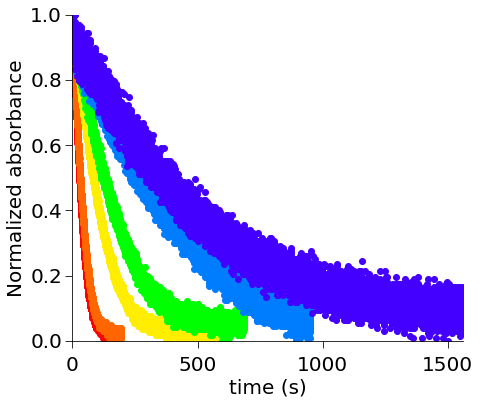

In [29]:
import matplotlib
import matplotlib.pyplot as plt
import glob
import codecs
import numpy as np
import pandas as pd
import os
from ipywidgets import Output
from scipy.optimize import curve_fit
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

path = result_dir + "*.csv"
paths = [p for p in glob.glob(path)]

color_list = ["#ff0000", "#ff6600", "#ffee00", "#00ff00", "#007dff", "#4400ff"]
y_min = 0
y_max = 1
x_min = 0
# x_ticks = [0, 5, 10, 15]
        
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 20

#軸主目盛り線の長さ
plt.rcParams["xtick.major.size"] = 7
plt.rcParams["ytick.major.size"] = 7
#x軸補助目盛り線の長さ
plt.rcParams["xtick.minor.size"] = 4

plt.rcParams["legend.frameon"] = False

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.set_xlabel('time (s)')
ax.set_ylabel('Normalized absorbance')

# 軸の最大値、最小値、表示メモリ設定
ax.set_ylim(y_min, y_max)
#         ax.set_xticks(x_ticks)

# x軸ラベルの下に空間を生成
# ax.get_xaxis().set_tick_params(pad=8)

# 目盛りを外に出す
ax.tick_params(direction='out')

# 2.5間隔で補助メモリ
#         ax.xaxis.set_minor_locator(ticker.MultipleLocator(2.5))

# 枠線の消去
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


for i, path in enumerate(paths):
    with codecs.open(path, "r", "UTF-8", "ignore") as file:
        df = pd.read_csv(file)
        x_max = df['norm_time'].loc[len(df) - 1]
        ax.set_xlim(x_min, x_max)
        x = df['norm_time']
        y = df['norm_abs']
        ax.plot(x, y, "o", color=color_list[i])

fig.savefig(result_dir + "curve_plot.png")